
# Mobile Money Data Preparation — Botswana diagnostics
**Author:** Generated for Mmopiemang Mmopiemang  
**Purpose:** Prepare and merge GSMA (Global Mobile Money Dataset 2024) and World Bank Global Findex (2025) for Botswana diagnostics and produce engineered features for modelling.  
**Files required (uploaded to `/data/`):**  
- `Global_Mobile_Money_Dataset_2024.xlsx` (GSMA workbook)  
- `GlobalFindexDatabase2025.csv` (Global Findex CSV)  


In [1]:

# Imports and configuration
import pandas as pd, numpy as np, re, os, matplotlib.pyplot as plt,seaborn as sns
from IPython.display import display
print("pandas version:", pd.__version__)
OUTPUT_DIR = "data/prep_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)


pandas version: 2.2.3


In [2]:


GSMA_XLSX = "data/Global_Mobile_Money_Dataset_2024.xlsx"
GSMA_SHEET = "All Data Table"
FINDEX_CSV = "data/GlobalFindexDatabase2025.csv"
SADC_COUNTRIES = ['Botswana','South Africa','Zambia','Namibia','Zimbabwe','Mozambique','Malawi','Lesotho','Eswatini','Tanzania','Angola','Democratic Republic Of The Congo']


## Helper functions

In [3]:


def standardise_country(s):
    if pd.isna(s): return s
    return str(s).strip().replace('\xa0',' ').title()

def find_date_cols(cols):
    return [c for c in cols if isinstance(c, str) and re.search(r'\d{2}/\d{2}/\d{4}', c)]

def detect_findex_columns(mm_df):
    # auto-detect common Findex variables
    mapping = {}
    for c in mm_df.columns:
        lc = c.lower()
        if 'mobile' in lc and 'account' in lc:
            mapping['mobile_account_share'] = c
        if 'fiaccount' in lc or ('formal' in lc and 'account' in lc):
            mapping.setdefault('formal_account_share', c)
        if 'account_t_d' in lc or (lc.startswith('account') and '_t_' in lc):
            mapping.setdefault('any_account_share', c)
        if 'save' in lc and ('_t_' in lc or lc.endswith('_s') or 'save_any' in lc):
            mapping.setdefault('saved_formal', c)
        if 'borrow' in lc and 'business' in lc:
            mapping.setdefault('borrow_business', c)
        if ('recv' in lc or 'received' in lc) and 'digital' in lc:
            mapping.setdefault('received_digital', c)
        if lc == 'pop_adult' or 'pop_adult' in lc:
            mapping.setdefault('pop_adult', c)
    return mapping


## Load GSMA sheet and melt date columns

In [4]:
print("Loading GSMA workbook...")
wb = pd.read_excel(GSMA_XLSX, sheet_name=None)
print("Sheets found:", list(wb.keys()))
if GSMA_SHEET not in wb:
    print("Warning: requested sheet not found; using first sheet instead:", list(wb.keys())[0])
    GSMA_SHEET = list(wb.keys())[0]
gsma = wb[GSMA_SHEET].copy()
print("GSMA shape:", gsma.shape)

date_cols = find_date_cols(gsma.columns)
print("Found date-like columns (count):", len(date_cols))
meta_cols = [c for c in ['Measure','Geo_view','Geo_name','Attribute','Unit','Metric'] if c in gsma.columns]
print("Meta columns:", meta_cols)

gsma_long = gsma.melt(id_vars=meta_cols, value_vars=date_cols, var_name='date_raw', value_name='value')
gsma_long['year'] = gsma_long['date_raw'].astype(str).str.extract(r'(20\d{2}|19\d{2})')[0].astype(float)
if 'Geo_name' in gsma_long.columns:
    gsma_long['country'] = gsma_long['Geo_name'].astype(str).map(standardise_country)
else:
    poss = [c for c in gsma_long.columns if 'geo' in c.lower() or 'country' in c.lower()]
    if poss:
        gsma_long['country'] = gsma_long[poss[0]].astype(str).map(standardise_country)

gsma_long['Measure'] = gsma_long['Measure'].astype(str)
gsma_long['Metric'] = gsma_long['Metric'].astype(str) if 'Metric' in gsma_long.columns else ""
gsma_long['value'] = pd.to_numeric(gsma_long['value'], errors='coerce')
print("GSMA long rows:", len(gsma_long))
display(gsma_long.head(6))


Loading GSMA workbook...
Sheets found: ['Read me ', 'Contents', 'Availabilty', 'Agents', 'Accounts', 'Usage - Regional', 'Usage - Product', 'All Data Table', 'Countries ']
GSMA shape: (595, 102)
Found date-like columns (count): 96
Meta columns: ['Measure', 'Geo_view', 'Geo_name', 'Attribute', 'Unit', 'Metric']
GSMA long rows: 57120


,Measure,Geo_view,Geo_name,Attribute,Unit,Metric,date_raw,value,year,country
0,Active Services,Region,East Asia and Pacific,Active Services,Services,Mobile Money Services,01/03/2001,NaN,2001.0,East Asia And Pacific
1,Active Services,Region,Europe and Central Asia,Active Services,Services,Mobile Money Services,01/03/2001,NaN,2001.0,Europe And Central Asia
2,Active Services,Region,Latin America and the Caribbean,Active Services,Services,Mobile Money Services,01/03/2001,NaN,2001.0,Latin America And The Caribbean
3,Active Services,Region,Middle East and North Africa,Active Services,Services,Mobile Money Services,01/03/2001,NaN,2001.0,Middle East And North Africa
4,Active Services,Region,South Asia,Active Services,Services,Mobile Money Services,01/03/2001,NaN,2001.0,South Asia
5,Active Services,Region,Sub-Saharan Africa,Active Services,Services,Mobile Money Services,01/03/2001,NaN,2001.0,Sub-Saharan Africa


# Keyword Extraction

In [5]:

measure_map = {
    'active_accounts': ['active account','active accounts','active, 30-day','active 30'],
    'registered_accounts': ['registered account','registered accounts'],
    'agents_per_100k': ['agent per','agents per','agents per 100','agents per 100k','agents'],
    'transaction_value': ['transaction value','transaction volume','txn value','transaction usd','transaction (usd)','total transaction value']
}

extracted = {}
for key,kws in measure_map.items():
    mask = pd.Series(False, index=gsma_long.index)
    for kw in kws:
        mask = mask | gsma_long['Measure'].str.contains(kw, case=False, na=False)
        mask = mask | gsma_long['Metric'].str.contains(kw, case=False, na=False)
    subset = gsma_long[mask].copy()
    if subset.empty:
        # loose match on first token
        subset = gsma_long[gsma_long['Measure'].str.contains(kws[0].split()[0], case=False, na=False)]
    if subset.empty:
        print(f'No GSMA rows matched for {key} with keywords {kws}.')
        continue
    agg = subset.groupby(['country','year'])['value'].agg('max').reset_index().rename(columns={'value':key})
    extracted[key] = agg
    print(f"Extracted {key}: sample rows:")
    display(agg.head())

# Merge extracted frames
from functools import reduce
if extracted:
    gsma_cy = reduce(lambda a,b: pd.merge(a,b,on=['country','year'], how='outer'), list(extracted.values()))
    print("GSMA country-year merged shape:", gsma_cy.shape)
    display(gsma_cy.head())
else:
    raise RuntimeError("No GSMA measures extracted. Adjust keywords or inspect the 'Measure' column.")


Extracted active_accounts: sample rows:


,country,year,active_accounts
0,Africa,2001.0,0.000000
1,Africa,2002.0,8.965242
2,Africa,2003.0,22.371973
3,Africa,2004.0,43.789539
4,Africa,2005.0,159.658927


Extracted registered_accounts: sample rows:


,country,year,registered_accounts
0,Africa,2001.0,0.000000
1,Africa,2002.0,522.017509
2,Africa,2003.0,1006.725380
3,Africa,2004.0,1626.362090
4,Africa,2005.0,4485.660850


Extracted agents_per_100k: sample rows:


,country,year,agents_per_100k
0,Africa,2001.0,0.000000
1,Africa,2002.0,0.843048
2,Africa,2003.0,1.856851
3,Africa,2004.0,3.231817
4,Africa,2005.0,10.017815


C:\Users\bida22-038\AppData\Local\Temp\ipykernel_21344\542069959.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = mask | gsma_long['Measure'].str.contains(kw, case=False, na=False)
C:\Users\bida22-038\AppData\Local\Temp\ipykernel_21344\542069959.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = mask | gsma_long['Metric'].str.contains(kw, case=False, na=False)


No GSMA rows matched for transaction_value with keywords ['transaction value', 'transaction volume', 'txn value', 'transaction usd', 'transaction (usd)', 'total transaction value'].
GSMA country-year merged shape: (336, 5)


,country,year,active_accounts,registered_accounts,agents_per_100k
0,Africa,2001.0,0.000000,0.000000,0.000000
1,Africa,2002.0,8.965242,522.017509,0.843048
2,Africa,2003.0,22.371973,1006.725380,1.856851
3,Africa,2004.0,43.789539,1626.362090,3.231817
4,Africa,2005.0,159.658927,4485.660850,10.017815


## Load Global Findex CSV and auto-detect variables

In [6]:


print("Loading Global Findex...")
findex = pd.read_csv(FINDEX_CSV, low_memory=False)
print("Findex shape:", findex.shape)
display(list(findex.columns)[:80])

# Standardise country and year
if 'countrynewwb' in findex.columns:
    findex['country'] = findex['countrynewwb'].map(standardise_country)
else:
    poss = [c for c in findex.columns if 'country' in c.lower()]
    if poss:
        findex['country'] = findex[poss[0]].map(standardise_country)
    else:
        raise RuntimeError("No country column found in Findex.")

# Detect variables
findex_map = detect_findex_columns(findex)
print("Auto-detected Findex columns:")
for k,v in findex_map.items():
    print(" -", k, "->", v)

# Build subset and rename to standardized names
use_cols = ['country','year'] + [v for v in findex_map.values() if v in findex.columns]
findex_sub = findex[use_cols].copy()
rename_map = {'country':'country','year':'year'}
rename_map.update({v:k for k,v in findex_map.items()})
findex_sub = findex_sub.rename(columns=rename_map)
for c in findex_sub.columns:
    if c not in ['country','year']:
        findex_sub[c] = pd.to_numeric(findex_sub[c], errors='coerce')
display(findex_sub.head())


Loading Global Findex...
Findex shape: (8564, 437)


['countrynewwb',
 'codewb',
 'year',
 'pop_adult',
 'regionwb24_hi',
 'incomegroupwb24',
 'group',
 'group2',
 'account_t_d',
 'fiaccount_t_d',
 'mobileaccount_t_d',
 'borrow_any_t_d',
 'fin4_d',
 'dig_acc',
 'fin11_2a',
 'fin11a',
 'fin11b',
 'fin11c',
 'fin11f',
 'fin11d',
 'fin11e',
 'fin14a',
 'fin14b',
 'fin14c',
 'fin14d',
 'fin13_1a',
 'fin13_1b',
 'fin26a',
 'fin26b',
 'fin27a',
 'fin27b',
 'fin17f',
 'fin17a_17a1_d',
 'fin17a',
 'fin17b',
 'fin17c',
 'fin22d',
 'fin22e',
 'fin22a_22a1_22g_d',
 'fin22a',
 'fin22a_1',
 'fin22b',
 'fin22c',
 'fin24sav',
 'fin24fam',
 'fin24work',
 'fin24bor',
 'fin24sell',
 'fin24other',
 'fin24aVD',
 'fin24aSD',
 'fin24aND',
 'fin24aSD_ND',
 'fin24aP',
 'fin24aN',
 'fin24sav_SD_ND',
 'fin24fam_SD_ND',
 'fin24work_SD_ND',
 'fin24bor_SD_ND',
 'fin24sell_SD_ND',
 'fin24other_SD_ND',
 'fin24sav_VD',
 'fin24fam_VD',
 'fin24work_VD',
 'fin24bor_VD',
 'fin24sell_VD',
 'fin24other_VD',
 'fh1',
 'fin28',
 'fh2',
 'fin29',
 'fin31a_31b',
 'fin30',
 'fin31

Auto-detected Findex columns:
 - pop_adult -> pop_adult
 - any_account_share -> account_t_d
 - formal_account_share -> fiaccount_t_d
 - mobile_account_share -> mobileaccount_t_d
 - saved_formal -> save_any_t_d


,country,year,pop_adult,any_account_share,formal_account_share,mobile_account_share,saved_formal
0,Afghanistan,2011,14575546.0,0.090050,0.090050,NaN,NaN
1,Albania,2011,2281010.0,0.282681,0.282681,NaN,NaN
2,Algeria,2011,26251587.0,0.332861,0.332861,NaN,NaN
3,Angola,2011,12779501.0,0.392035,0.392035,NaN,NaN
4,Argentina,2011,30685516.0,0.331302,0.331302,NaN,NaN


## Merge GSMA country-year with Findex subset

In [7]:


merged = pd.merge(findex_sub, gsma_cy, on=['country','year'], how='left')
print("Merged shape:", merged.shape)
display(merged.head())

# Feature engineering examples
mm_df = merged.copy()

# Add pop_adult if available in original Findex
if 'pop_adult' in findex.columns and 'pop_adult' not in mm_df.columns:
    mm_df = mm_df.merge(findex[['country','year','pop_adult']].drop_duplicates(), on=['country','year'], how='left')

if 'active_accounts' in mm_df.columns and 'pop_adult' in mm_df.columns:
    mm_df['active_accounts_per_1000'] = mm_df['active_accounts'] / mm_df['pop_adult'] * 1000

if 'transaction_value' in mm_df.columns and 'active_accounts' in mm_df.columns:
    mm_df['txn_per_active'] = mm_df['transaction_value'] / mm_df['active_accounts'].replace({0:np.nan})

if 'mobile_account_share' in mm_df.columns and 'formal_account_share' in mm_df.columns:
    mm_df['mobile_to_formal_ratio'] = mm_df['mobile_account_share'] / mm_df['formal_account_share'].replace({0:np.nan})

if 'borrow_business' in mm_df.columns and 'saved_formal' in mm_df.columns:
    mm_df['borrow_to_save_ratio'] = mm_df['borrow_business'] / mm_df['saved_formal'].replace({0:np.nan})

for c in ['active_accounts','transaction_value','mobile_account_share']:
    if c in mm_df.columns:
        mm_df[f'delta_{c}'] = mm_df.groupby('country')[c].diff()

# SADC relative penetration index
if 'mobile_account_share' in mm_df.columns:
    sadc_avg = mm_df[mm_df['country'].isin(SADC_COUNTRIES)].groupby('year')['mobile_account_share'].mean().reset_index().rename(columns={'mobile_account_share':'sadc_mobile_avg'})
    mm_df = mm_df.merge(sadc_avg, on='year', how='left')
    mm_df['relative_penetration_index'] = mm_df['mobile_account_share'] - mm_df['sadc_mobile_avg']

# Save outputs
out_raw = os.path.join(OUTPUT_DIR, 'merged_country_year_raw.csv')
out_feat = os.path.join(OUTPUT_DIR, 'merged_country_year_features.csv')
merged.to_csv(out_raw, index=False)
mm_df.to_csv(out_feat, index=False)
print('Saved raw merged CSV to', out_raw)
print('Saved feature CSV to', out_feat)
display(mm_df.head())


Merged shape: (8564, 10)


,country,year,pop_adult,any_account_share,formal_account_share,mobile_account_share,saved_formal,active_accounts,registered_accounts,agents_per_100k
0,Afghanistan,2011,14575546.0,0.090050,0.090050,NaN,NaN,NaN,NaN,NaN
1,Albania,2011,2281010.0,0.282681,0.282681,NaN,NaN,NaN,NaN,NaN
2,Algeria,2011,26251587.0,0.332861,0.332861,NaN,NaN,NaN,NaN,NaN
3,Angola,2011,12779501.0,0.392035,0.392035,NaN,NaN,NaN,NaN,NaN
4,Argentina,2011,30685516.0,0.331302,0.331302,NaN,NaN,NaN,NaN,NaN


Saved raw merged CSV to data/prep_outputs\merged_country_year_raw.csv
Saved feature CSV to data/prep_outputs\merged_country_year_features.csv


,country,year,pop_adult,any_account_share,formal_account_share,mobile_account_share,saved_formal,active_accounts,registered_accounts,agents_per_100k,active_accounts_per_1000,mobile_to_formal_ratio,delta_active_accounts,delta_mobile_account_share,sadc_mobile_avg,relative_penetration_index
0,Afghanistan,2011,14575546.0,0.090050,0.090050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,2011,2281010.0,0.282681,0.282681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,2011,26251587.0,0.332861,0.332861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Angola,2011,12779501.0,0.392035,0.392035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Argentina,2011,30685516.0,0.331302,0.331302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Botswana diagnostics

,country,year,pop_adult,any_account_share,formal_account_share,mobile_account_share,saved_formal,active_accounts,registered_accounts,agents_per_100k,active_accounts_per_1000,mobile_to_formal_ratio,delta_active_accounts,delta_mobile_account_share,sadc_mobile_avg,relative_penetration_index
16,Botswana,2011,1340324.0,0.302600,0.302600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,Botswana,2011,1340324.0,0.321595,0.321595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
742,Botswana,2011,1340324.0,0.283603,0.283603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,Botswana,2011,1340324.0,0.409162,0.409162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3491,Botswana,2011,1340324.0,0.352055,0.352055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3492,Botswana,2011,1340324.0,0.203047,0.203047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2128,Botswana,2011,1340324.0,0.142189,0.142189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5157,Botswana,2011,1340324.0,0.556624,0.556624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6525,Botswana,2011,1340324.0,0.184952,0.184952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6524,Botswana,2011,1340324.0,0.391095,0.391095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


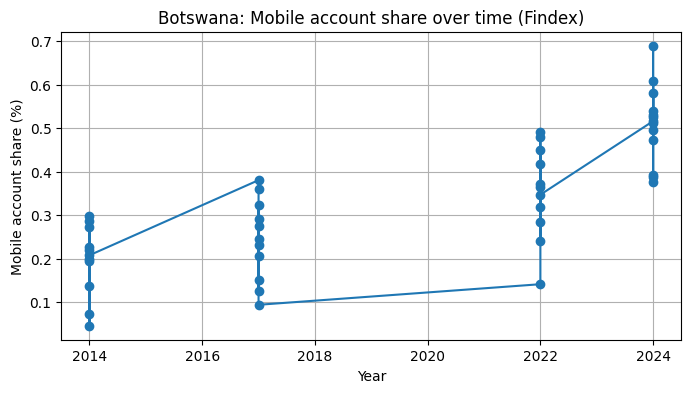

<Figure size 800x400 with 0 Axes>

In [ ]:

"""
bots = mm_df[mm_df['country']=='Botswana'].sort_values('year')
if bots.empty:
    print('No Botswana rows present in merged data. Check country naming.')
else:
    display(bots)
    # Plot mobile account share over time (if present)
    if 'mobile_account_share' in bots.columns and bots['mobile_account_share'].notna().any():
        plt.figure(figsize=(8,4))
        plt.plot(bots['year'], bots['mobile_account_share'], marker='o')
        plt.title('Botswana: Mobile account share over time (Findex)')
        plt.xlabel('Year'); plt.ylabel('Mobile account share (%)'); plt.grid(True); plt.show()
    # Plot active accounts and agents if present
    plt.figure(figsize=(8,4))
    plotted = False
    if 'active_accounts' in bots.columns and bots['active_accounts'].notna().any():
        plt.plot(bots['year'], bots['active_accounts'], marker='o', label='Active accounts (GSMA raw)'); plotted = True
    if 'agents_per_100k' in bots.columns and bots['agents_per_100k'].notna().any():
        plt.plot(bots['year'], bots['agents_per_100k'], marker='o', label='Agents per 100k'); plotted = True
    if plotted:
        plt.title('Botswana: GSMA indicators over time'); plt.xlabel('Year'); plt.legend(); plt.grid(True); plt.show()
    if 'transaction_value' in bots.columns and bots['transaction_value'].notna().any():
        plt.figure(figsize=(8,4))
        plt.plot(bots['year'], bots['transaction_value'], marker='o')
        plt.title('Botswana: Transaction value over time (check GSMA Unit)'); plt.xlabel('Year'); plt.ylabel('Transaction value (raw)'); plt.grid(True); plt.show()
"""

,country,year,pop_adult,any_account_share,formal_account_share,mobile_account_share,saved_formal,active_accounts,registered_accounts,agents_per_100k,active_accounts_per_1000,mobile_to_formal_ratio,delta_active_accounts,delta_mobile_account_share,sadc_mobile_avg,relative_penetration_index
16,Botswana,2011,1340324.0,0.302600,0.302600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,Botswana,2011,1340324.0,0.321595,0.321595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
742,Botswana,2011,1340324.0,0.283603,0.283603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,Botswana,2011,1340324.0,0.409162,0.409162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3491,Botswana,2011,1340324.0,0.352055,0.352055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3492,Botswana,2011,1340324.0,0.203047,0.203047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2128,Botswana,2011,1340324.0,0.142189,0.142189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5157,Botswana,2011,1340324.0,0.556624,0.556624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6525,Botswana,2011,1340324.0,0.184952,0.184952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6524,Botswana,2011,1340324.0,0.391095,0.391095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


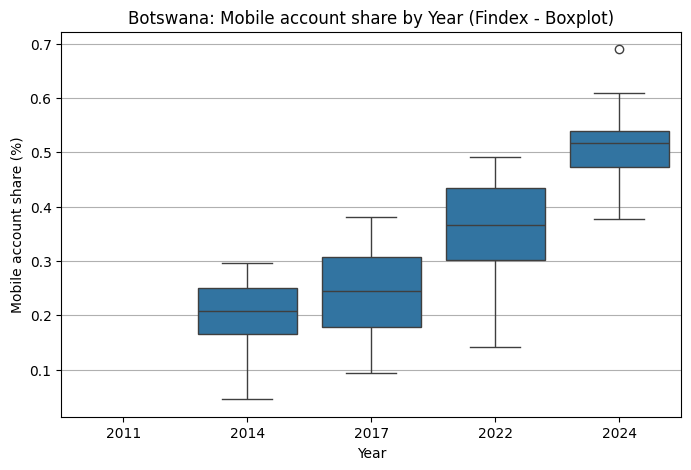

<Figure size 800x400 with 0 Axes>

In [8]:
bots = mm_df[mm_df['country']=='Botswana'].sort_values('year')
if bots.empty:
    print('No Botswana rows present in merged data. Check country naming.')
else:
    display(bots) 
    
    if 'mobile_account_share' in bots.columns and bots['mobile_account_share'].notna().any():
        plt.figure(figsize=(8, 5))
        
        
        # sns.boxplot plots the distribution of 'mobile_account_share' for each unique 'year'
        sns.boxplot(x='year', y='mobile_account_share', data=bots)
        
        
        plt.title('Botswana: Mobile account share by Year (Findex - Boxplot)')
        plt.xlabel('Year')
        plt.ylabel('Mobile account share (%)')
        plt.grid(axis='y') 
        plt.show()
        
    
    plt.figure(figsize=(8,4))
    plotted = False
    if 'active_accounts' in bots.columns and bots['active_accounts'].notna().any():
        plt.plot(bots['year'], bots['active_accounts'], marker='o', label='Active accounts (GSMA raw)'); plotted = True
    if 'agents_per_100k' in bots.columns and bots['agents_per_100k'].notna().any():
        plt.plot(bots['year'], bots['agents_per_100k'], marker='o', label='Agents per 100k'); plotted = True
    if plotted:
        plt.title('Botswana: GSMA indicators over time'); plt.xlabel('Year'); plt.legend(); plt.grid(True); plt.show()
        
    if 'transaction_value' in bots.columns and bots['transaction_value'].notna().any():
        plt.figure(figsize=(8,4))
        plt.plot(bots['year'], bots['transaction_value'], marker='o')
        plt.title('Botswana: Transaction value over time (check GSMA Unit)'); plt.xlabel('Year'); plt.ylabel('Transaction value (raw)'); plt.grid(True); plt.show()

### Botswana: Mobile Account Share Trend Analysis

The mobile account share in Botswana demonstrates a strong, consistent upward trend between 2014 and 2024, as evidenced by the shift in the boxplot distributions.

The median mobile account share started at approximately 21% in 2014 and saw a gradual increase to ≈25% by 2017. The most substantial acceleration occurred in the following period, with the median jumping to ≈37% in 2022. By 2024, the median crossed the majority threshold, reaching ≈51%.